In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import pickle 
import sys

sys.path.append('/dfs/user/kexinh/perturb_GNN/pertnet/')
#sys.path.append('../../gears_misc/')

from model import linear_model
from utils import parse_any_pert
from tqdm import tqdm
from data import PertDataloader
from pertdata import PertData
import torch
from inference_new import evaluate, compute_metrics, deeper_analysis, GI_subgroup, non_dropout_analysis

import warnings
warnings.filterwarnings("ignore")
import argparse

seed = 5
split_num = seed
dataset_name = 'norman'
graph_type = 'grnboost'

In [2]:
data_path = '/dfs/project/perturb-gnn/datasets/data/'
split_num = seed
graph_type = graph_type
filter_ = 'top50'
method = 'linear'
dataset = dataset_name
#data_path = '/dfs/project/perturb-gnn/datasets/Norman2019/Norman2019_hvg+perts_more_de.h5ad'
data_path = '/dfs/project/perturb-gnn/datasets/data/norman/perturb_processed.h5ad'
de_adata = sc.read_h5ad('/dfs/project/perturb-gnn/datasets/Norman2019/Norman2019_hvg+perts_more_de.h5ad')

adata = sc.read(data_path)
if 'gene_symbols' not in adata.var.columns.values:
    adata.var['gene_symbols'] = adata.var['gene_name']
    
if dataset == 'Norman2019':    
    split_path = '/dfs/user/kexinh/perturb_GNN/pertnet/splits/Norman2019_simulation_' + str(split_num) + '_0.1.pkl'
else:
    split_path = '/dfs/project/perturb-gnn/datasets/data/' + dataset + '/splits/' + dataset + '_simulation_' + str(split_num) + '_0.75.pkl'
    
split = pickle.load(open(split_path, 'rb'))

condition2set = {}
    
for i,j in split.items():
    for k in j:
        condition2set[k] = i
        
#adata.obs['split_status'] = [condition2set[i] for i in adata.obs.condition.values]
#adata_train = adata[adata.obs['split_status'] == 'train']

In [3]:
graph_path = '/dfs/project/perturb-gnn/graphs/linear/' + graph_type + '/norman_' + str(split_num) + '_' + str(filter_) + '.csv'
weights_path = '/dfs/project/perturb-gnn/graphs/linear/' + graph_type + '/norman_' + str(split_num) + '_' + str(filter_) + '_' + method + '_learntweights.csv'

gene_list = adata.var.gene_name.values

model = linear_model(graph_path=graph_path, 
             weights_path=weights_path, 
             gene_list = gene_list,
             binary=False, 
             pos_edges=False, 
             hops=1,
             species='human')

Edges: 14170


In [4]:
gene_path = None
    
pert_data = PertData('/dfs/project/perturb-gnn/datasets/data', gene_path = gene_path) # specific saved folder
pert_data.load(data_path = '/dfs/project/perturb-gnn/datasets/data/' + dataset) 

pert_data.prepare_split(split = 'simulation', seed = split_num)


### TODO --------
## Modify split here

pert_data.get_dataloader(batch_size = 128, test_batch_size = 128)

pred_delta = {pert: model.simulate_pert(parse_any_pert(pert)) for pert in split['test']}
adata_ctrl = adata[adata.obs.condition == 'ctrl']

Found local copy...
These perturbations are not in the GO graph and is thus not able to make prediction for...
['RHOXF2BB+ctrl' 'LYL1+IER5L' 'ctrl+IER5L' 'KIAA1804+ctrl' 'IER5L+ctrl'
 'RHOXF2BB+ZBTB25' 'RHOXF2BB+SET']
Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:3
combo_seen1:56
combo_seen2:18
unseen_single:40
Done!
Creating dataloaders....
Done!


In [5]:
pert_cat = []
pred = []
truth = []
pred_de = []
truth_de = []
results = {}

for batch in tqdm(pert_data.dataloader['test_loader']):
    
    pert_cat.extend(batch.pert)
    p = np.array([pred_delta[i]+adata_ctrl.X[np.random.randint(0, adata_ctrl.shape[0])].toarray().reshape(-1,) for i in batch.pert])
    t = batch.y

    pred.extend(p)
    truth.extend(t.cpu())

    # Differentially expressed genes
    for itr, de_idx in enumerate(batch.de_idx):
        pred_de.append(p[itr, de_idx])
        truth_de.append(t[itr, de_idx])
        
# all genes
results['pert_cat'] = np.array(pert_cat)

pred = np.stack(pred)
truth = torch.stack(truth)
results['pred']= pred
results['truth']= truth.detach().cpu().numpy()

pred_de = np.stack(pred_de)
truth_de = torch.stack(truth_de)
results['pred_de']= pred_de
results['truth_de']= truth_de.detach().cpu().numpy()


100%|█████████████████████████████████████████| 259/259 [01:32<00:00,  2.79it/s]


## CellOracle Evaluation

In [6]:
perturbed_expression = np.load('CellOracle_preds_pert_exp_split_'+str(split_num)+'.npy', allow_pickle=True).item()
#perturbed_expression = np.load('CellOracle_preds_pert_exp_split_retry_'+str(split_num)+'.npy', allow_pickle=True).item()

In [7]:
adata_df = adata.to_df()
adata_df['condition'] = adata.obs['condition'].values
mean_adata_df = adata_df.groupby('condition').mean()
condition_name_dict = adata.obs.set_index('condition').loc[:,'condition_name'].to_dict()
de_adata.obs['condition_name'] = de_adata.obs['condition'].map(condition_name_dict)

In [8]:
def get_de_idx(c, num_de_genes = 20):
    de_idx = np.where(adata.var_names.isin(
        np.array(de_genes[condition_name_dict[c]][:num_de_genes])))[0]
    return de_idx

In [9]:
test_res = {}

perturbed_expression_df = pd.DataFrame(perturbed_expression).T
de_genes = adata.uns['rank_genes_groups_cov_all']

test_res['pert_cat'] = perturbed_expression_df.index.values
test_res['pred'] = perturbed_expression_df.values
test_res['truth'] = mean_adata_df.loc[test_res['pert_cat']].values

In [10]:
## Computing DE genes
pred_de_list = []
truth_de_list = []

for itr, c in enumerate(test_res['pert_cat']):
    de_idx = get_de_idx(c)
    pred_de_list.append(test_res['pred'][itr][de_idx])
    truth_de_list.append(test_res['truth'][itr][de_idx])
    
test_res['pred_de'] = np.array(pred_de_list)
test_res['truth_de'] = np.array(truth_de_list)

In [11]:
for k in test_res:
    test_res[k] = np.repeat(test_res[k], 50, 0)

In [12]:
import wandb 
wandb.init(project='co_baseline', entity='yroohani', name= '_CO_'.join([dataset_name, str(split_num)]))

args = {}
args['wandb'] = True

out = deeper_analysis(de_adata, test_res)
out_non_dropout = non_dropout_analysis(de_adata, test_res)

metrics = ['pearson_delta']
metrics_non_dropout = ['frac_opposite_direction_top20_non_dropout', 'frac_sigma_below_1_non_dropout', 'mse_top20_de_non_dropout']
    
if args['wandb']:
    for m in metrics:
        wandb.log({'test_' + m: np.mean([j[m] for i,j in out.items() if m in j])})

    for m in metrics_non_dropout:
        wandb.log({'test_' + m: np.mean([j[m] for i,j in out_non_dropout.items() if m in j])})    

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: yroohani. Use `wandb login --relogin` to force relogin


## GRN-Baseline Evaluation

In [13]:
test_metrics, test_pert_res = compute_metrics(results)
test_res = results

# Subset to those perturbations that can be predicted in CellOracle
test_res_small = {}
perts_to_keep = np.where([x in perturbed_expression.keys() for x in test_res['pert_cat']])
for k in test_res.keys():
    test_res_small[k] = test_res[k][perts_to_keep]

wandb.init(project='co_baseline', entity='yroohani', name= '_GRN_Base_'.join([dataset_name, str(split_num)]))
args = {}
args['wandb'] = True

out = deeper_analysis(adata, test_res_small)
out_non_dropout = non_dropout_analysis(adata, test_res_small)

metrics = ['pearson_delta']
metrics_non_dropout = ['frac_opposite_direction_top20_non_dropout', 'frac_sigma_below_1_non_dropout', 'mse_top20_de_non_dropout']
    
if args['wandb']:
    for m in metrics:
        wandb.log({'test_' + m: np.mean([j[m] for i,j in out.items() if m in j])})

    for m in metrics_non_dropout:
        wandb.log({'test_' + m: np.mean([j[m] for i,j in out_non_dropout.items() if m in j])})        


test_frac_opposite_direction_top20_non_dropout,▁
test_frac_sigma_below_1_non_dropout,▁
test_mse_top20_de_non_dropout,▁
test_pearson_delta,▁
test_frac_opposite_direction_top20_non_dropout,0.44189
test_frac_sigma_below_1_non_dropout,0.0027
test_mse_top20_de_non_dropout,1.7526
test_pearson_delta,0.13631


## GEARS Evaluation

In [14]:
import sys
sys.path.append('../../')

from gears_temp.gears import PertData, GEARS
import numpy as np
import pandas as pd
import scanpy as sc

In [15]:
## GEARS prediction
data_path = '/dfs/project/perturb-gnn/datasets/data/'
data_name = 'norman'
model_name = 'gears'

gears_model = GEARS(pert_data, device = 'cuda:5', 
                        weight_bias_track = False, 
                        proj_name = 'gears', 
                        exp_name = model_name)
gears_model.load_pretrained('../Evaluation/model_ckpt/norman_gears_run' + str(seed) + '/')

In [16]:
key_map = {}
pert_cat = []
pred = []
truth = []
pred_de = []
truth_de = []
results = {}

for k in perturbed_expression.keys():
    pert = [p for p in k.split('+') if p != 'ctrl']
    
    print(pert)
    key_map['_'.join(pert)] = k    
    gears_model.predict([pert])

['KLF1']
['KLF1', 'FOXA1']
['KLF1']
['RREB1']
['CEBPE', 'KLF1']
['DLX2']
['JUN', 'CEBPA']
['TP73']
['IKZF3']
['POU3F2', 'FOXL2']
['HOXB9']
['HOXB9']
['AHR', 'KLF1']
['CEBPB', 'CEBPA']
['DLX2']
['CEBPA']
['FOSB', 'CEBPB']
['KLF1', 'CEBPA']
['FOXA3', 'HOXB9']
['CEBPE', 'CEBPA']
['IKZF3']
['FOXF1', 'HOXB9']
['CEBPB']
['CEBPB', 'OSR2']
['CEBPA']
['FOXA1', 'HOXB9']
['CEBPE', 'SPI1']
['ETS2', 'IKZF3']
['LYL1', 'CEBPB']
['CEBPB']
['FOSB', 'IKZF3']
['FOSB', 'OSR2']
['FOXL2', 'HOXB9']
['JUN', 'CEBPB']
['CEBPE', 'CEBPB']
['FOXA1', 'FOXF1']
['SNAI1', 'DLX2']


In [17]:
gears_test_res = {}

gears_pred = pd.DataFrame(gears_model.saved_pred).T
gears_pred.index = gears_pred.index.map(key_map)

de_genes = adata.uns['rank_genes_groups_cov_all']
gears_test_res['pert_cat'] = gears_pred.index.values
gears_test_res['pred'] = gears_pred.values
gears_test_res['truth'] = mean_adata_df.loc[gears_test_res['pert_cat']].values

In [18]:
## Computing DE genes
pred_de_list = []
truth_de_list = []

for itr, c in enumerate(gears_test_res['pert_cat']):
    de_idx = get_de_idx(c)
    pred_de_list.append(gears_test_res['pred'][itr][de_idx])
    truth_de_list.append(gears_test_res['truth'][itr][de_idx])
    
gears_test_res['pred_de'] = np.array(pred_de_list)
gears_test_res['truth_de'] = np.array(truth_de_list)

In [19]:
for k in gears_test_res:
    gears_test_res[k] = np.repeat(gears_test_res[k], 50, 0)

In [20]:
import wandb 
wandb.init(project='co_baseline', entity='yroohani', name= '_GEARS_'.join([dataset_name, str(split_num)]))

args = {}
args['wandb'] = True

out = deeper_analysis(de_adata, gears_test_res)
out_non_dropout = non_dropout_analysis(de_adata, gears_test_res)

metrics = ['pearson_delta']
metrics_non_dropout = ['frac_opposite_direction_top20_non_dropout', 'frac_sigma_below_1_non_dropout', 'mse_top20_de_non_dropout']
    
if args['wandb']:
    for m in metrics:
        wandb.log({'test_' + m: np.mean([j[m] for i,j in out.items() if m in j])})

    for m in metrics_non_dropout:
        wandb.log({'test_' + m: np.mean([j[m] for i,j in out_non_dropout.items() if m in j])})    

test_frac_opposite_direction_top20_non_dropout,▁
test_frac_sigma_below_1_non_dropout,▁
test_mse_top20_de_non_dropout,▁
test_pearson_delta,▁
test_frac_opposite_direction_top20_non_dropout,0.39459
test_frac_sigma_below_1_non_dropout,0.50405
test_mse_top20_de_non_dropout,0.78903
test_pearson_delta,0.21152


## No pert baseline

In [21]:
import sys
sys.path.append('../../')

from gears_temp.gears import PertData, GEARS
import numpy as np
import pandas as pd
import scanpy as sc

## No perturb prediction
data_path = '/dfs/project/perturb-gnn/datasets/data/'
data_name = 'norman'
model_name = 'gears'

gears_model = GEARS(pert_data, device = 'cuda:5', 
                        weight_bias_track = False, 
                        proj_name = 'gears', 
                        exp_name = model_name)
gears_model.load_pretrained('../Evaluation/model_ckpt/norman_gears_run' + str(seed) + '/')

gears_model.no_perturb=True
gears_model.model.no_perturb = True

key_map = {}
pert_cat = []
pred = []
truth = []
pred_de = []
truth_de = []
results = {}

for k in perturbed_expression.keys():
    pert = [p for p in k.split('+') if p != 'ctrl']
    
    print(pert)
    key_map['_'.join(pert)] = k    
    gears_model.predict([pert])

    
gears_test_res = {}

gears_pred = pd.DataFrame(gears_model.saved_pred).T
gears_pred.index = gears_pred.index.map(key_map)

de_genes = adata.uns['rank_genes_groups_cov_all']
gears_test_res['pert_cat'] = gears_pred.index.values
gears_test_res['pred'] = gears_pred.values
gears_test_res['truth'] = mean_adata_df.loc[gears_test_res['pert_cat']].values
## Computing DE genes
pred_de_list = []
truth_de_list = []

for itr, c in enumerate(gears_test_res['pert_cat']):
    de_idx = get_de_idx(c)
    pred_de_list.append(gears_test_res['pred'][itr][de_idx])
    truth_de_list.append(gears_test_res['truth'][itr][de_idx])
    
gears_test_res['pred_de'] = np.array(pred_de_list)
gears_test_res['truth_de'] = np.array(truth_de_list)
for k in gears_test_res:
    gears_test_res[k] = np.repeat(gears_test_res[k], 50, 0)


['KLF1']
['KLF1', 'FOXA1']
['KLF1']
['RREB1']
['CEBPE', 'KLF1']
['DLX2']
['JUN', 'CEBPA']
['TP73']
['IKZF3']
['POU3F2', 'FOXL2']
['HOXB9']
['HOXB9']
['AHR', 'KLF1']
['CEBPB', 'CEBPA']
['DLX2']
['CEBPA']
['FOSB', 'CEBPB']
['KLF1', 'CEBPA']
['FOXA3', 'HOXB9']
['CEBPE', 'CEBPA']
['IKZF3']
['FOXF1', 'HOXB9']
['CEBPB']
['CEBPB', 'OSR2']
['CEBPA']
['FOXA1', 'HOXB9']
['CEBPE', 'SPI1']
['ETS2', 'IKZF3']
['LYL1', 'CEBPB']
['CEBPB']
['FOSB', 'IKZF3']
['FOSB', 'OSR2']
['FOXL2', 'HOXB9']
['JUN', 'CEBPB']
['CEBPE', 'CEBPB']
['FOXA1', 'FOXF1']
['SNAI1', 'DLX2']


In [22]:
import wandb 
wandb.init(project='co_baseline', entity='yroohani', name= '_No_perturb_'.join([dataset_name, str(split_num)]))

args = {}
args['wandb'] = True

out = deeper_analysis(de_adata, gears_test_res)
out_non_dropout = non_dropout_analysis(de_adata, gears_test_res)

metrics = ['pearson_delta']
metrics_non_dropout = ['frac_opposite_direction_top20_non_dropout', 'frac_sigma_below_1_non_dropout', 'mse_top20_de_non_dropout']
    
if args['wandb']:
    for m in metrics:
        wandb.log({'test_' + m: np.mean([j[m] for i,j in out.items() if m in j])})

    for m in metrics_non_dropout:
        wandb.log({'test_' + m: np.mean([j[m] for i,j in out_non_dropout.items() if m in j])})    

test_frac_opposite_direction_top20_non_dropout,▁
test_frac_sigma_below_1_non_dropout,▁
test_mse_top20_de_non_dropout,▁
test_pearson_delta,▁
test_frac_opposite_direction_top20_non_dropout,0.08548
test_frac_sigma_below_1_non_dropout,0.0
test_mse_top20_de_non_dropout,0.34941
test_pearson_delta,0.65896


## Plot results

In [31]:
import pandas as pd 
import wandb
import seaborn as sns
import matplotlib.pyplot as plt
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("yroohani/co_baseline")

summary_list, config_list, name_list = [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })

In [32]:
run = 6
gears_runs = ['norman_GEARS_' + str(i) for i in range(1, run)]
grn_baseline_runs = ['norman_GRN_Base_' + str(i) for i in range(1, run)]
cell_oracle_runs = ['norman_CO_retry_' + str(i) for i in range(1, run)]
no_perturb_runs = ['norman_No_perturb_' + str(i) for i in range(1, run)]

In [33]:
res_df = runs_df[runs_df.name.isin(gears_runs + grn_baseline_runs + cell_oracle_runs + no_perturb_runs)]

def normalize_name(x):
    if x in gears_runs:
        return 'GEARS'
    elif x in grn_baseline_runs:
        return 'GRN-Baseline'
    elif x in cell_oracle_runs:
        return 'CellOracle'
    else:
        return 'No-Perturb'

In [34]:
color_pal = {
'GRN-Baseline': (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
'CellOracle': (0.4, 0.7607843137254902, 0.6470588235294118),
'GEARS': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
'No-Perturb': (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)}

In [41]:
metrics = ['test_mse_top20_de_non_dropout'
          #'test_pearson_delta'
          ]
metrics_name_map = {'test_mse_top20_de_non_dropout': 'MSE',
                   'test_pearson_delta': 'Pearson'}
method = []
category = []
result = []

for m in metrics:
    method += [normalize_name(i) for i in res_df.name.values]
    category += [metrics_name_map[m]] * len(res_df)
    result += res_df.summary.apply(lambda x: x[m]).values.tolist()
    
    
out = {}
out['method'] = pd.Series(method)
out['category'] = pd.Series(category)
out['Top 20 DE MSE'] = pd.Series(result)

pal_order = [color_pal[i] for i in pd.DataFrame(out).method.unique()]

out = pd.DataFrame(out)

normalize = dict(out[out.method == 'No-Perturb'].groupby('category')['Top 20 DE MSE'].agg(np.mean))

norm = []
for i in out[['category', 'Top 20 DE MSE']].values:
    norm.append(i[1]/normalize[i[0]])
    
out['Normalized MSE of Top 20 DE Genes'] = norm

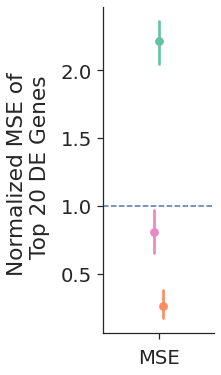

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wand

In [42]:
sns.set(rc={'figure.figsize':(2,6)})
sns.set_theme(style="ticks", rc={"axes.facecolor": (0, 0, 0, 0)}, font = "Helvetica", font_scale=1.8)

g = sns.pointplot('category', 'Normalized MSE of Top 20 DE Genes', 
    data=pd.DataFrame(out), 
    order = ['MSE'], 
    hue = 'method',
    palette= [color_pal['GRN-Baseline'], color_pal['CellOracle'], color_pal['GEARS']],         
    dodge=True, 
    join=False,
    hue_order = ['GRN-Baseline', 'CellOracle', 'GEARS'])
sns.despine()
g.legend_.remove()
g.set(xlabel=None, )
g.axhline(1, linestyle="dashed")

#plt.legend(bbox_to_anchor=(1, 0.9), facecolor='white')

plt.ylabel("Normalized MSE of \n Top 20 DE Genes",labelpad=10)
plt.tick_params(axis='x', which='major', pad=10)
plt.tick_params(axis='y', which='major', pad=5)

In [37]:
metrics = ['test_pearson_delta'
          ]
metrics_name_map = {'test_mse_top20_de_non_dropout': 'MSE',
                   'test_pearson_delta': 'Pearson'}
method = []
category = []
result = []

for m in metrics:
    method += [normalize_name(i) for i in res_df.name.values]
    category += [metrics_name_map[m]] * len(res_df)
    result += res_df.summary.apply(lambda x: x[m]).values.tolist()
    
    
out = {}
out['method'] = pd.Series(method)
out['category'] = pd.Series(category)
out['Pearson Delta'] = pd.Series(result)

pal_order = [color_pal[i] for i in pd.DataFrame(out).method.unique()]

out = pd.DataFrame(out)

vals = []
for i in out[['category', 'Pearson Delta']].values:
    vals.append(i[1]/1)
    
out['Pearson Delta'] = vals

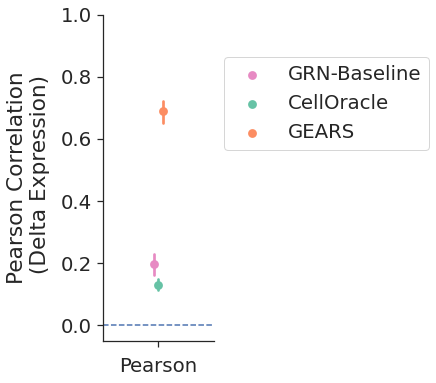

In [40]:
sns.set(rc={'figure.figsize':(2,6)})
sns.set_theme(style="ticks", rc={"axes.facecolor": (0, 0, 0, 0)}, font = "Helvetica", font_scale=1.8)

g = sns.pointplot('category', 'Pearson Delta', 
    data=pd.DataFrame(out), 
    hue = 'method',
    palette= [color_pal['GRN-Baseline'], color_pal['CellOracle'], color_pal['GEARS']],         
    dodge=True, 
    join=False,
    hue_order = ['GRN-Baseline', 'CellOracle', 'GEARS'])
sns.despine()
#g.legend_.remove()
g.set(xlabel=None, )
g.axhline(0, linestyle="dashed")

plt.legend(bbox_to_anchor=(1, 0.9), facecolor='white')
plt.ylabel("Pearson Correlation\n (Delta Expression)",labelpad=10)
plt.ylim([-0.05,1])
plt.tick_params(axis='x', which='major', pad=10)
plt.tick_params(axis='y', which='major', pad=5)